# **CS570 - Homework 2**


In this assignment we will implement the **GraphSAGE** ([Hamilton et al. (2017)](https://arxiv.org/abs/1706.02216)) layer and **GAT** ([Veličković et al. (2018)](https://arxiv.org/abs/1710.10903)) layer. Then we will run our models on the CORA dataset, which is a standard node classification dataset on a citation network benchmark.

**Note**: Make sure to **sequentially run all the cells in each section** so that the intermediate variables / packages will carry over to the next cell.

# Device
We recommend using a GPU for this assignment.

Please click `Runtime` and then `Change runtime type`. Then set the `hardware accelerator` to **GPU**.

## Installation

In [ ]:
# import os, sys
# # 挂载google drive
# from google.colab import drive
# drive.mount('/content/gdrive')

# nb_path = '/content/gdrive/MyDrive/Python'
# os.symlink('/content/gdrive/My Drive/Colab Notebooks', nb_path)
# sys.path.insert(0, nb_path)  # or append(nb_path)

In [ ]:
# !pip install --target=$nb_path torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cu111.html
# # !pip install --target=$nb_path torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cu111.html
# !pip install --target=$nb_path torch-geometric

In [ ]:
import sys
from google.colab import drive
drive.mount('/content/gdrive')
sys.path.insert(0,"/content/gdrive/MyDrive/Python")

Mounted at /content/gdrive


In [ ]:
# # Install torch geometric
# import os
# !pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cu111.html
# !pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cu111.html
# !pip install torch-geometric

In [ ]:
import torch_geometric
torch_geometric.__version__

'2.2.0'

# 1) GNN Layers

## Implementing Layer Modules
For this assignment, we provide a build upon a general Graph Neural Network Stack, into which we will be able to plugin our own module implementations: GraphSAGE and GAT.

We will then use our layer implemenations to complete node classification on the CORA dataset, a standard citation network benchmark. In this dataset, nodes correspond to documents and edges correspond to undirected citations. Each node or document in the graph is assigned a class label and features based on the documents binarized bag-of-words representation. Specifically, the Cora graph has 2708 nodes, 5429 edges, 7 prediction classes, and 1433 features per node.

## GNN Stack Module

Below is the implementation of a general GNN stack, where we can plugin any GNN layer, such as **GraphSage**, **GAT**, etc. This module is provided for you. Your implementations of the **GraphSage** and **GAT** layers will function as components in the GNNStack Module.

In [ ]:
import torch
import torch_scatter
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

from torch import Tensor
from typing import Union, Tuple, Optional
from torch_geometric.typing import (OptPairTensor, Adj, Size, NoneType,
                                    OptTensor)

from torch.nn import Parameter, Linear
from torch_sparse import SparseTensor, set_diag
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax

class GNNStack(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, args, emb=False):
        super(GNNStack, self).__init__()
        conv_model = self.build_conv_model(args.model_type)
        self.convs = nn.ModuleList()
        self.convs.append(conv_model(input_dim, hidden_dim))
        assert (args.num_layers >= 1), 'Number of layers is not >=1'
        for l in range(args.num_layers-1):
            self.convs.append(conv_model(args.heads * hidden_dim, hidden_dim))

        # post-message-passing
        self.post_mp = nn.Sequential(
            nn.Linear(args.heads * hidden_dim, hidden_dim), nn.Dropout(args.dropout),
            nn.Linear(hidden_dim, output_dim))

        self.dropout = args.dropout
        self.num_layers = args.num_layers

        self.emb = emb

    def build_conv_model(self, model_type):
        if model_type == 'GraphSage':
            return GraphSage
        elif model_type == 'GAT':
            # When applying GAT with num heads > 1, you need to modify the
            # input and output dimension of the conv layers (self.convs),
            # to ensure that the input dim of the next layer is num heads
            # multiplied by the output dim of the previous layer.
            # HINT: In case you want to play with multiheads, you need to change the for-loop that builds up self.convs to be
            # self.convs.append(conv_model(hidden_dim * num_heads, hidden_dim)),
            # and also the first nn.Linear(hidden_dim * num_heads, hidden_dim) in post-message-passing.
            return GAT

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout,training=self.training)

        x = self.post_mp(x)

        if self.emb == True:
            return x

        return F.log_softmax(x, dim=1)

    def loss(self, pred, label):
        return F.nll_loss(pred, label)

## Creating Our Own Message Passing Layer

Now let's start implementing our own message passing layers! Working through this part will help us become acutely familiar with the behind the scenes work of implementing Pytorch Message Passing Layers, allowing us to build our own GNN models. To do so, we will work with and implement 3 critcal functions needed to define a PyG Message Passing Layer: `forward`, `message`, and `aggregate`.

Before diving head first into the coding details, let us quickly review the key components of the message passing process. To do so, we will focus on a single round of messsage passing with respect to a single central node $x$. Before message passing, $x$ is associated with a feature vector $x^{l-1}$, and the goal of message passing is to update this feature vector as $x^l$. To do so, we implement the following steps: 1) each neighboring node $v$ passes its current message $v^{l-1}$ across the edge $(x, v)$ - 2) for the node $x$, we aggregate all of the messages of the neighboring nodes (for example through a sum or mean) - and 3) we transform the aggregated information by for example applying linear and non-linear transformations. Altogether, the message passing process is applied such that every node $u$ in our graph updates its embedding by acting as the central node $x$ in step 1-3 described above.

Now, we extending this process to that of a single message passing layer, the job of a message passing layer is to update the current feature representation or embedding of each node in a graph by propagating and transforming information within the graph. Overall, the general paradigm of a message passing layers is: 1) pre-processing -> 2) **message passing** / propagation -> 3) post-processing.

The `forward` fuction that we will implement for our message passing layer captures this execution logic. Namely, the `forward` function handles the pre and post-processing of node features / embeddings, as well as initiates message passing by calling the `propagate` function.


The `propagate` function encapsulates the message passing process! It does so by calling three important functions: 1) `message`, 2) `aggregate`, and 3) `update`. Our implementation will vary slightly from this, as we will not explicitly implement `update`, but instead place the logic for updating node embeddings after message passing and within the `forward` function. To be more specific, after information is propagated (message passing), we can further transform the node embeddings outputed by `propagate`. Therefore, the output of `forward` is exactly the node embeddings after one GNN layer.

Lastly, before starting to implement our own layer, let us dig a bit deeper into each of the functions described above:

1.

```
def propagate(edge_index, x=(x_i, x_j), extra=(extra_i, extra_j), size=size):
```
Calling `propagate` initiates the message passing process. Looking at the function parameters, we highlight a couple of key parameters.

  - `edge_index` is passed to the forward function and captures the edge structure of the graph.
  - `x=(x_i, x_j)` represents the node features that will be used in message passing. In order to explain why we pass the tuple `(x_i, x_j)`, we first look at how our edges are represented. For every edge $(i, j) \in \mathcal{E}$, we can differentiate $i$ as the source or central node ($x_{central}$) and j as the neighboring node ($x_{neighbor}$).
  
    Taking the example of message passing above, for a central node $u$ we will aggregate and transform all of the messages associated with the nodes $v$ s.t. $(u, v) \in \mathcal{E}$ (i.e. $v \in \mathcal{N}_{u}$). Thus we see, the subscripts `_i` and `_j` allow us to specifcally differenciate features associated with central nodes (i.e. nodes  recieving message information) and neighboring nodes (i.e. nodes passing messages).

    This is definitely a somewhat confusing concept; however, one key thing to remember / wrap your head around is that depending on the perspective, a node $x$ acts as a central node or a neighboring node. In fact, in undirected graphs we store both edge directions (i.e. $(i, j)$ and $(j, i)$). From the central node perspective, `x_i`, x is collecting neighboring information to update its embedding. From a neighboring node perspective, `x_j`, x is passing its message information along the edge connecting it to a different central node.

  - `extra=(extra_i, extra_j)` represents additional information that we can associate with each node beyond its current feature embedding. In fact, we can include as many additional parameters of the form `param=(param_i, param_j)` as we would like. Again, we highlight that indexing with `_i` and `_j` allows us to differentiate central and neighboring nodes.

  The output of the `propagate` function is a matrix of node embeddings after the message passing process and has shape $[N, d]$.

2.
```
def message(x_j, ...):
```
The `message` function is called by propagate and constructs the messages from
neighboring nodes $j$ to central nodes $i$ for each edge $(i, j)$ in *edge_index*. This function can take any argument that was initially passed to `propagate`. Furthermore, we can again differentiate central nodes and neighboring nodes by appending `_i` or `_j` to the variable name, .e.g. `x_i` and `x_j`. Looking more specifically at the variables, we have:

  - `x_j` represents a matrix of feature embeddings for all neighboring nodes passing their messages along their respective edge (i.e. all nodes $j$ for edges $(i, j) \in \mathcal{E}$). Thus, its shape is $[|\mathcal{E}|, d]$!
  - In implementing GAT we will see how to access additional variables passed to propagate

  Critically, we see that the output of the `message` function is a matrix of neighboring node embeddings ready to be aggregated, having shape $[|\mathcal{E}|, d]$.

3.
```
def aggregate(self, inputs, index, dim_size = None):
```
Lastly, the `aggregate` function is used to aggregate the messages from neighboring nodes. Looking at the parameters we highlight:

  - `inputs` represents a matrix of the messages passed from neighboring nodes (i.e. the output of the `message` function).
  - `index` has the same shape as `inputs` and tells us the central node that corresponding to each of the rows / messages $j$ in the `inputs` matrix. Thus, `index` tells us which rows / messages to aggregate for each central node.

  The output of `aggregate` is of shape $[N, d]$.


For additional resources refer to the PyG documentation for implementing custom message passing layers: https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html

## GraphSage Implementation

For our first GNN layer, we will implement the well known GraphSage ([Hamilton et al. (2017)](https://arxiv.org/abs/1706.02216)) layer!

For a given *central* node $v$ with current embedding $h_v^{l-1}$, the message passing update rule to tranform $h_v^{l-1} \rightarrow h_v^l$ is as follows:

\begin{equation}
h_v^{(l)} = W_l\cdot h_v^{(l-1)} + W_r \cdot AGG(\{h_u^{(l-1)}, \forall u \in N(v) \})
\end{equation}

where $W_1$ and $W_2$ are learanble weight matrices and the nodes $u$ are *neighboring* nodes. Additionally, we use mean aggregation for simplicity:

\begin{equation}
AGG(\{h_u^{(l-1)}, \forall u \in N(v) \}) = \frac{1}{|N(v)|} \sum_{u\in N(v)} h_u^{(l-1)}
\end{equation}

One thing to note is that we're adding a **skip connection** to our GraphSage implementation through the term $W_l\cdot h_v^{(l-1)}$.

Before implementing this update rule, we encourage you to think about how different parts of the formulas above correspond with the functions outlined earlier: 1) `forward`, 2) `message`, and 3) `aggregate`. As a hint, we are given what the aggregation function is (i.e. mean aggregation)! Now the question remains, what are the messages passed by each neighbor nodes and when do we call the `propagate` function?

Note: in this case the message function or messages are actually quite simple. Additionally, remember that the `propagate` function encapsulates the operations of / the outputs of the combined `message` and `aggregate` functions.


Lastly, $\ell$-2 normalization of the node embeddings is applied after each iteration.


<font color='red'>For the following questions, please DON'T refer to any existing implementations online.</font>

In [ ]:
class GraphSage(MessagePassing):

    def __init__(self, in_channels, out_channels, normalize = True,
                 bias = False, **kwargs):
        super(GraphSage, self).__init__(**kwargs)

        ############################################################################
        # TODO: Your code here!
        # Define the layers needed for the message and update functions below.
        ############################################################################
        self.lin_l = Linear(in_channels, out_channels, bias=False)
        self.lin_r = Linear(in_channels, out_channels, bias=False)
        self.reset_parameters()

    def reset_parameters(self):
        self.lin_l.reset_parameters()
        self.lin_r.reset_parameters()

    def forward(self, x, edge_index, size = None):
        ############################################################################
        # TODO: Your code here!
        # Implement message passing, as well as any post-processing (our update rule).
        # 1. Call the propagate function to conduct the message passing.
        #    1.1 See the description of propagate above or the following link for more information:
        #        https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html
        #    1.2 We will only use the representation for neighbor nodes (x_j), so by default
        #        we pass the same representation for central and neighbor nodes as x=(x, x).
        # 2. Update our node embedding with skip connection from the previous layer.
        # 3. If normalize is set, do L-2 normalization (defined in
        #    torch.nn.functional)
        #
        ############################################################################
        output = self.propagate(edge_index, x=(x, x))
        output = self.lin_r(output)
        x = self.lin_l(x)
        norm_output = F.normalize(x + output, 2)
        return norm_output

    def message(self, x_j):
        ############################################################################
        # TODO: Your code here!
        # Implement your message function here.
        # Hint: Look at the formulation of the mean aggregation function, focusing on
        # what message each neighboring node passes.
        ############################################################################
        return x_j

    def aggregate(self, inputs, index, dim_size = None):

        ############################################################################
        # TODO: Your code here!
        # Implement your aggregate function here.
        # See here as how to use torch_scatter.scatter:
        # https://pytorch-scatter.readthedocs.io/en/latest/functions/scatter.html#torch_scatter.scatter
        ############################################################################
        output = torch_scatter.scatter(inputs, index, dim=0, dim_size=dim_size, reduce='mean')
        return output


## GAT Implementation

Attention mechanisms have become the state-of-the-art in many sequence-based tasks such as machine translation and learning sentence representations. One of the major benefits of attention-based mechanisms is their ability to focus on the most relevant parts of the input to make decisions. In this problem, we will see how attention mechanisms can be used to perform node classification over graph-structured data through the usage of Graph Attention Networks (GATs) ([Veličković et al. (2018)](https://arxiv.org/abs/1710.10903)).

The building block of the Graph Attention Network is the graph attention layer, which is a variant of the aggregation function. Let $N$ be the number of nodes and $F$ be the dimension of the feature vector for each node. The input to each graph attentional layer is a set of node features: $\mathbf{h} = \{\overrightarrow{h_1}, \overrightarrow{h_2}, \dots, \overrightarrow{h_N}$\}, $\overrightarrow{h_i} \in R^F$. The output of each graph attentional layer is a new set of node features, which may have a new dimension $F'$: $\mathbf{h'} = \{\overrightarrow{h_1'}, \overrightarrow{h_2'}, \dots, \overrightarrow{h_N'}\}$, with $\overrightarrow{h_i'} \in \mathbb{R}^{F'}$.

We will now describe how this transformation is performed for each graph attention layer. First, a shared linear transformation parametrized by the weight matrix $\mathbf{W} \in \mathbb{R}^{F' \times F}$ is applied to every node.

Next, we perform self-attention on the nodes. We use a shared attention function $a$:
\begin{equation}
a : \mathbb{R}^{F'} \times \mathbb{R}^{F'} \rightarrow \mathbb{R}.
\end{equation}

that computes the attention coefficients capturing the importance of node $j$'s features to node $i$:
\begin{equation}
e_{ij} = a(\mathbf{W_l}\overrightarrow{h_i}, \mathbf{W_r} \overrightarrow{h_j})
\end{equation}

The most general formulation of self-attention allows every node to attend to all other nodes which drops all structural information. However, to utilize graph structure in the attention mechanisms, we use **masked attention**. In masked attention, we only compute attention coefficients $e_{ij}$ for nodes $j \in \mathcal{N}_i$ where $\mathcal{N}_i$ is some neighborhood of node $i$ in the graph.

To easily compare coefficients across different nodes, we normalize the coefficients across $j$ using a softmax function:
\begin{equation}
\alpha_{ij} = \text{softmax}_j(e_{ij}) = \frac{\exp(e_{ij})}{\sum_{k \in \mathcal{N}_i} \exp(e_{ik})}
\end{equation}

For this problem, our attention mechanism $a$ will be a single-layer feedforward neural network parametrized by a weight vectors $\overrightarrow{a_l} \in \mathbb{R}^{F'}$ and $\overrightarrow{a_r} \in \mathbb{R}^{F'}$, followed by a LeakyReLU nonlinearity (with negative input slope 0.2). Let $\cdot^T$ represent transposition and $||$ represent concatenation. The coefficients computed by our attention mechanism may be expressed as:

\begin{equation}
\alpha_{ij} = \frac{\exp\Big(\text{LeakyReLU}\Big(\overrightarrow{a_l}^T \mathbf{W_l} \overrightarrow{h_i} + \overrightarrow{a_r}^T\mathbf{W_r}\overrightarrow{h_j}\Big)\Big)}{\sum_{k\in \mathcal{N}_i} \exp\Big(\text{LeakyReLU}\Big(\overrightarrow{a_l}^T \mathbf{W_l} \overrightarrow{h_i} + \overrightarrow{a_r}^T\mathbf{W_r}\overrightarrow{h_k}\Big)\Big)}
\end{equation}

For the following questions, we denote `alpha_l` = $\alpha_l = [...,\overrightarrow{a_l}^T \mathbf{W_l} \overrightarrow{h_i},...] \in \mathcal{R}^n$ and `alpha_r` = $\alpha_r = [..., \overrightarrow{a_r}^T \mathbf{W_r} \overrightarrow{h_j}, ...] \in \mathcal{R}^n$.


At every layer of GAT, after the attention coefficients are computed for that layer, the aggregation function can be computed by a weighted sum of neighborhood messages, where weights are specified by $\alpha_{ij}$.

Now, we use the normalized attention coefficients to compute a linear combination of the features corresponding to them. These aggregated features will serve as the final output features for every node.

\begin{equation}
h_i' = \sum_{j \in \mathcal{N}_i} \alpha_{ij} \mathbf{W_r} \overrightarrow{h_j}.
\end{equation}

At this point, we have covered a lot of information! Before reading further about multi-head attention, we encourage you to go again through the excersize of thinking about what components of the attention mechanism correspond with the different functions: 1) `forward`, 2) `message`, and 3 `aggregate`.

- Hint 1: Our aggregation is very similar to that of GraphSage except now we are using sum aggregation.
- Hint 2: The terms we aggregate over again represent the individual message that each neighbor node j sends. Thus, we see that $\alpha_{ij}$ is part of the message each node sends and is thus computed during the message step. This makes sense since an attention weight is associated with each edge in the graph.
- Hint 3: Look at the terms in the definition of $\alpha_{ij}$. What values do we want to pre-process and pass as parameters to the `propagate` function. The parameters of `message(..., x_j, alpha_j, alpha_i, ...)` should give a good hint.  

### Multi-Head Attention
To stabilize the learning process of self-attention, we use multi-head attention. To do this we use $K$ independent attention mechanisms, or ``heads'' compute output features as in the above equations. Then, we concatenate these output feature representations:

\begin{equation}
    \overrightarrow{h_i}' = ||_{k=1}^K \Big(\sum_{j \in \mathcal{N}_i} \alpha_{ij}^{(k)} \mathbf{W_r}^{(k)} \overrightarrow{h_j}\Big)
\end{equation}

where $||$ is concentation, $\alpha_{ij}^{(k)}$ are the normalized attention coefficients computed by the $k$-th attention mechanism $(a^k)$, and $\mathbf{W}^{(k)}$ is the corresponding input linear transformation's weight matrix. Note that for this setting, $\mathbf{h'} \in \mathbb{R}^{KF'}$.

In [ ]:
class GAT(MessagePassing):

    def __init__(self, in_channels, out_channels, heads = 2,
                 negative_slope = 0.2, dropout = 0., **kwargs):
        super(GAT, self).__init__(node_dim=0, **kwargs)

        ############################################################################
        # TODO: Your code here!
        # Define the layers needed for the message functions below.
        #
        # Pay attention to dimensions of the linear layers, since we're using
        # multi-head attention.
        ############################################################################
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.negative_slope = negative_slope
        self.dropout = dropout

        self.lin_l = Linear(in_channels, heads * out_channels, bias=False)
        self.lin_r = Linear(in_channels, heads * out_channels, bias=False)
        self.att_l = Parameter(torch.rand(1, heads, out_channels))
        self.att_r = Parameter(torch.rand(1, heads, out_channels))

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.lin_l.weight)
        nn.init.xavier_uniform_(self.lin_r.weight)
        nn.init.xavier_uniform_(self.att_l)
        nn.init.xavier_uniform_(self.att_r)

    def forward(self, x, edge_index, size = None):

        ############################################################################
        # TODO: Your code here!
        # Implement message passing, as well as any pre- and post-processing (our update rule).
        # 1. First apply linear transformation to node embeddings, and split that
        #    into multiple heads. We use the same representations for source and
        #    target nodes, but apply different linear weights (W_l and W_r)
        # 2. Calculate alpha vectors for central nodes (alpha_l) and neighbor nodes (alpha_r).
        # 3. Call propagate function to conduct the message passing.
        #    3.1 Remember to pass alpha = (alpha_l, alpha_r) as a parameter.
        #    3.2 See there for more information: https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html
        # 4. Transform the output back to the shape of [N, H * C].
        ############################################################################
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        x_l = self.lin_l(x)
        x_r = self.lin_r(x)
        x_l = torch.reshape(x_l, (-1, self.heads, self.out_channels))
        x_r = torch.reshape(x_r, (-1, self.heads, self.out_channels))
        alpha_l = (self.att_l * x_l).sum(axis=-1)
        alpha_r = (self.att_r * x_r).sum(axis=-1)
        output = self.propagate(edge_index, x=(x_l, x_r), alpha=(alpha_l, alpha_r), size=size)
        output = torch.reshape(output, (-1, self.heads * self.out_channels))
        return output


    def message(self, x_j, alpha_j, alpha_i, index, ptr, size_i):

        ############################################################################
        # TODO: Your code here!
        # Implement your message function. Putting the attention in message
        # instead of in update is a little tricky.
        # 1. Calculate the final attention weights using alpha_i and alpha_j,
        #    and apply leaky Relu.
        # 2. Calculate softmax over the neighbor nodes for all the nodes. Use
        #    torch_geometric.utils.softmax instead of the one in Pytorch.
        # 3. Apply dropout to attention weights (alpha).
        # 4. Multiply embeddings and attention weights. As a sanity check, the output
        #    should be of shape [E, H, C].
        # 5. ptr (LongTensor, optional): If given, computes the softmax based on
        #    sorted inputs in CSR representation. You can simply pass it to softmax.
        ############################################################################
        alpha = F.leaky_relu(alpha_j + alpha_i, self.negative_slope)
        alpha = softmax(alpha, index, ptr, size_i)
        alpha = F.dropout(alpha, p=self.dropout, training=self.training).unsqueeze(-1)
        output = x_j * alpha
        return output


    def aggregate(self, inputs, index, dim_size = None):

        ############################################################################
        # TODO: Your code here!
        # Implement your aggregate function here.
        # See here as how to use torch_scatter.scatter: https://pytorch-scatter.readthedocs.io/en/latest/_modules/torch_scatter/scatter.html
        # Pay attention to "reduce" parameter is different from that in GraphSage.
        ############################################################################
        output = torch_scatter.scatter(inputs, index, dim=0, dim_size=dim_size, reduce='sum')
        return output


## Building Optimizers

Please build an Adam optimizer and return it in this function. But feel free to try some other types of optimizers on your own.

In [ ]:
import torch.optim as optim

def build_optimizer(args, params):
  if args.opt == 'adam':
        opt = optim.Adam(params, lr=args.lr, weight_decay=args.weight_decay)
  return opt

## Training and Testing

Test your model every 10 epochs and save the accuracy to the file *CORA-GAT.txt* or *CORA-GraphSage.txt* recordingly.

In [ ]:
import time

import networkx as nx
import numpy as np
import torch
import torch.optim as optim
from tqdm import trange
import pandas as pd
import copy

from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader

import torch_geometric.nn as pyg_nn

import matplotlib.pyplot as plt


def train(dataset, args):

    print("Node task. test set size:", np.sum(dataset[0]['test_mask'].numpy()))
    print()
    test_loader = loader = DataLoader(dataset, batch_size=args.batch_size, shuffle=False)

    # build model
    model = GNNStack(dataset.num_node_features, args.hidden_dim, dataset.num_classes, args)
    ############################################################################
    # TODO: Your code here!
    # Train your model and return training loss and test accuracy (and/or others).
    # Correct implementation would lead to accuracy at least 70%.
    ############################################################################
    epoch_list = []
    loss_list = []
    acc_list = []
    data = dataset[0]
    opt = build_optimizer(args, model.parameters())

    f = open('/content/gdrive/MyDrive/CORA-' + args.model_type +'.txt', 'w')
    for i in range(args.epochs):
        opt.zero_grad()
        model.train()
        output = model(data)
        loss = F.nll_loss(output[data['train_mask']], data['y'][data['train_mask']])
        loss.backward()
        opt.step()
        if (i + 1) % 10 == 0:
            acc = test(dataset, model, is_validation=False, save_model_preds=False, model_type=args.model_type)
            f.write('Epoch:' + str(i + 1) + ', Accuracy on Test set:' + str(acc) + '\n')
            print('Epoch:{}, Loss:{}, Accuracy on Test set:{}'.format(i + 1, loss.item(), acc))
            epoch_list.append(i + 1)
            loss_list.append(loss.item())
            acc_list.append(acc)
    f.close()
    return epoch_list, loss_list, acc_list

def test(loader, test_model, is_validation=False, save_model_preds=False, model_type=None):
    test_model.eval()
    correct = 0
    total = 0

    # Note that Cora is only one graph!
    for data in loader:
    ############################################################################
    # TODO: Your code here!
    # Evaluate your model on the test set and return the accuracy.
    ############################################################################
        with torch.no_grad():
            output = test_model(data)
            pred = output.argmax(dim=1)
            name = ''
            if is_validation:
              name = data['val_mask']
            else:
              name = data['test_mask']

        correct += (pred[name] == data['y'][name]).sum()
        total += name.sum()
        acc = correct / total
    return acc

class objectview(object):
    def __init__(self, d):
        self.__dict__ = d


In [ ]:
def plot_res(title, ylabel, x, y):
    plt.plot(x, y)
    plt.title(title)
    plt.xlabel('Epoches')
    plt.ylabel(ylabel)
    plt.show()

Node task. test set size: 1000

Epoch:10, Loss:1.1468366384506226, Accuracy on Test set:0.453000009059906
Epoch:20, Loss:0.34213918447494507, Accuracy on Test set:0.6620000004768372
Epoch:30, Loss:0.2137737274169922, Accuracy on Test set:0.7009999752044678
Epoch:40, Loss:0.19093553721904755, Accuracy on Test set:0.7329999804496765
Epoch:50, Loss:0.07853207737207413, Accuracy on Test set:0.7400000095367432
Epoch:60, Loss:0.05885857716202736, Accuracy on Test set:0.7549999952316284
Epoch:70, Loss:0.049712829291820526, Accuracy on Test set:0.734000027179718
Epoch:80, Loss:0.19811014831066132, Accuracy on Test set:0.7390000224113464
Epoch:90, Loss:0.08630524575710297, Accuracy on Test set:0.7590000033378601
Epoch:100, Loss:0.06432691216468811, Accuracy on Test set:0.7369999885559082
Epoch:110, Loss:0.08375382423400879, Accuracy on Test set:0.7260000109672546
Epoch:120, Loss:0.07113278657197952, Accuracy on Test set:0.7279999852180481
Epoch:130, Loss:0.06288468837738037, Accuracy on Test se

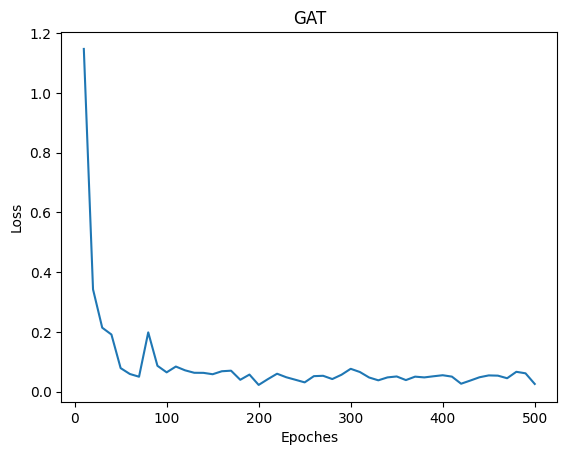

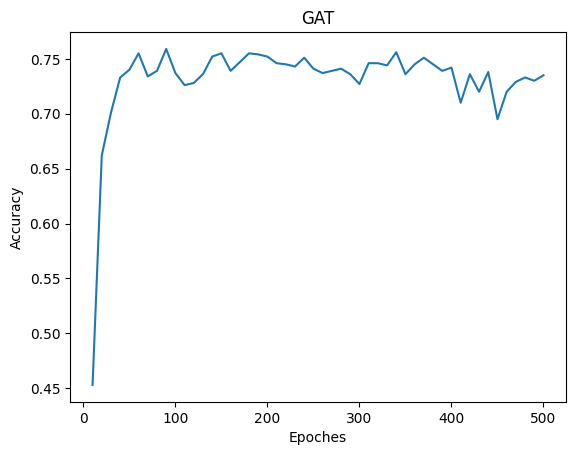

Node task. test set size: 1000

Epoch:10, Loss:1.7025357484817505, Accuracy on Test set:0.6399999856948853
Epoch:20, Loss:1.0528035163879395, Accuracy on Test set:0.7639999985694885
Epoch:30, Loss:0.5678430199623108, Accuracy on Test set:0.7630000114440918
Epoch:40, Loss:0.35484734177589417, Accuracy on Test set:0.7839999794960022
Epoch:50, Loss:0.2868683934211731, Accuracy on Test set:0.7870000004768372
Epoch:60, Loss:0.15060649812221527, Accuracy on Test set:0.777999997138977
Epoch:70, Loss:0.3056361675262451, Accuracy on Test set:0.7739999890327454
Epoch:80, Loss:0.31643274426460266, Accuracy on Test set:0.7749999761581421
Epoch:90, Loss:0.21169111132621765, Accuracy on Test set:0.7680000066757202
Epoch:100, Loss:0.2181372344493866, Accuracy on Test set:0.7680000066757202
Epoch:110, Loss:0.22375881671905518, Accuracy on Test set:0.781000018119812
Epoch:120, Loss:0.1369311362504959, Accuracy on Test set:0.781000018119812
Epoch:130, Loss:0.19659730792045593, Accuracy on Test set:0.762

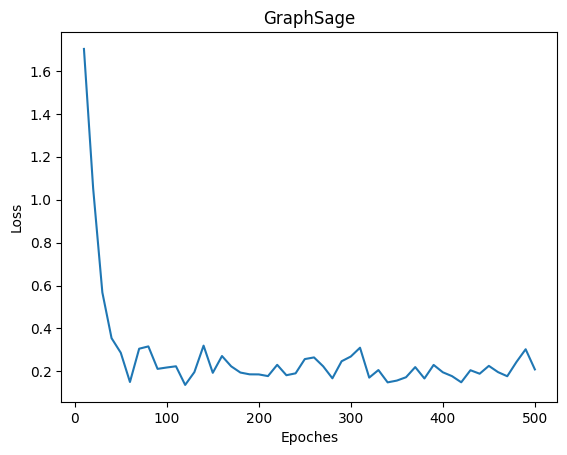

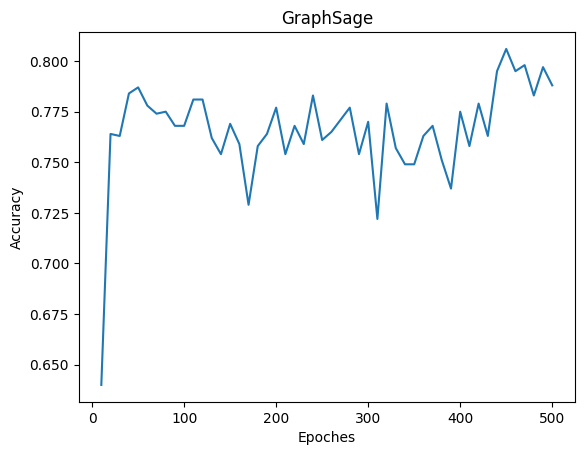

In [ ]:
for args in [
    {'model_type': 'GraphSage', 'dataset': 'cora', 'num_layers': 2, 'heads': 1, 'batch_size': 32, 'hidden_dim': 32, 'dropout': 0.5, 'epochs': 500, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'weight_decay': 5e-3, 'lr': 0.01},
]:
    args = objectview(args)
    for model in ['GAT', 'GraphSage']:
        args.model_type = model

        # Match the dimension.
        if model == 'GAT':
          args.heads = 2
        else:
          args.heads = 1

        if args.dataset == 'cora':
            dataset = Planetoid(root='/tmp/cora', name='Cora')
        else:
            raise NotImplementedError("Unknown dataset")
        ############################################################################
        # TODO: Your code here!
        # Train the model and plot the training loss and test accuracy for both GAT and GraphSage
        ############################################################################
        epoch_list, loss_list, acc_list = train(dataset, args)
        plot_res(model, 'Loss', epoch_list, loss_list)
        plot_res(model, 'Accuracy', epoch_list, acc_list)



## Question 1: What is the best accuracy obtained on test set for GAT? (10 points)


Run the cells above and save your GAT model accuracy every ten epochs to the file *CORA-GAT.txt*.

Under default parameters, the best accuracy of GAT is: 0.7559

## Question 2: What is the best accuracy obtained on test set for GraphSage? (10 points)


Run the cells above and save your GraphSage model accuracy every ten epochs to the file *CORA-GraphSage.txt*.

Under default parameters, the best accuracy GraphSage is: 0.8059

## Question 3: Increase the number of GNN layers and observe how the performance changes. Write down you observation and analysis. (10 points)


When number of layers increases, the performance drops. When number of layers is two, the model has the best performance. I think this is because more layers may cause the model become overfit.

## Question 4: Change the number of attention heads and observe how the performance changes. Write down you observation and analysis. (10 points)


When number of heads increases, the performance increases slightly. I think this is because when heads increases, each head can focus on smaller part of the dataset, which can be more precise and more information can be learnt.